In [13]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd

In [ ]:
model = read_sbml_model('data/iML1515_5htp_1st_strategy.xml')

**Checking max 5-HTP production and respective growth rate if objective value is changed to the 5-HTP export reaction**

In [ ]:
# Finding the flux of the phhA reaction
with model:
    print(model.reactions.phhA)
    model.objective = model.reactions.phhA
    solution = model.optimize()
    max_5HTP_production = solution.objective_value
    print("HTP flux", max_5HTP_production)
    print("Biomass flux", solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

**We can see here, that when we have optimal flux towards 5-HTP production, then there will be no flux towards biomass production, thus no growth of the cell.
Let's try and optimize for both 5-HTP and biomass production**

In [7]:
# Getting the flux towards 5-HTP and biomass respectively, when optimized for both reactions
model.objective = {model.reactions.phhA: 0.5}
solution = model.optimize()
print("5-HTP flux", solution.objective_value)
model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
solution = model.optimize()
print("Biomass flux", solution.objective_value)

5-HTP flux 2.1396021699819188
Biomass flux 0.4384986072134841


We can see here that the flux towards biomass and 5-HTP production are both half of their previous optimal flux, which make sense now that they share the flux

**Let's now observe how the growth rate changes with increasing 5-HTP export flux**

In [13]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [14]:
ppp_5HTP = production_envelope(model,
                    reactions=[model.reactions.phhA],
                    objective=model.reactions.BIOMASS_Ec_iML1515_core_75p37M)

In [15]:
ppp_5HTP

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,phhA
0,EX_glc__D_e,0.0,0.0,NaN,0.876997,1.161751e+01,NaN,0.000000
1,EX_glc__D_e,0.0,0.0,NaN,0.831248,1.101147e+01,NaN,0.225221
2,EX_glc__D_e,0.0,0.0,NaN,0.785499,1.040543e+01,NaN,0.450443
3,EX_glc__D_e,0.0,0.0,NaN,0.739749,9.799397e+00,NaN,0.675664
4,EX_glc__D_e,0.0,0.0,NaN,0.694000,9.193359e+00,NaN,0.900885
5,EX_glc__D_e,0.0,0.0,NaN,0.647766,8.580901e+00,NaN,1.126106
6,EX_glc__D_e,0.0,0.0,NaN,0.601497,7.967979e+00,NaN,1.351328
7,EX_glc__D_e,0.0,0.0,NaN,0.555228,7.355058e+00,NaN,1.576549
8,EX_glc__D_e,0.0,0.0,NaN,0.508959,6.742136e+00,NaN,1.801770
9,EX_glc__D_e,0.0,0.0,NaN,0.462690,6.129215e+00,NaN,2.026992


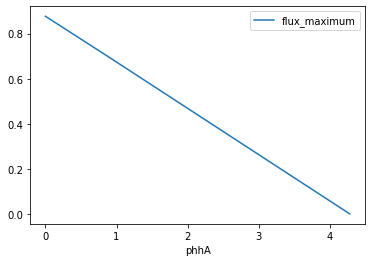

In [16]:
ppp_5HTP.plot(x='phhA', y='flux_maximum')

**Optmizing 5-HTP production and growth rate**

In [17]:
from cobra.flux_analysis import flux_variability_analysis

In [18]:
hydroxy_trp_flux_analysis = flux_variability_analysis(model, model.reactions.phhA, fraction_of_optimum = 0.5)
print(hydroxy_trp_flux_analysis)

      minimum   maximum
phhA      0.0  2.144746


In [19]:
hydroxy_trp_flux_analysis = float(flux_variability_analysis(model, model.reactions.phhA, fraction_of_optimum = 0.5)["maximum"][0])
print(hydroxy_trp_flux_analysis)

2.1447464147568795


Keeping growth rate at 50%, we get around 50% of maximum 5-HTP flux, which is the same result as when optimizing for both fluxes.

**Knocking out a single gene and setting the objective value of the model for 5-HTP export flux**

Only non-zero biomass production flux knock-outs are selected

In [20]:
for gene in model.genes:
    with model:
        gene.knock_out()
        model.objective = model.reactions.phhA
        solution = model.optimize()
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print ('5-HTP export flux:', solution.fluxes.tph, 'Gene ID:', gene.id, 'Biomass production:', solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)

No solutions displayed, no single knock-outs and optmization to maximum 5-HTP production yields positive growth rate

**Knocking out a single gene, running optimisation for max biomass production flux and observing 5-HTP export flux**

Only non-zero 5-HTP export flux knock-outs are selected

In [21]:
knock_out_list = pd.DataFrame(columns=['Gene ID', '5-HTP export flux', 'Biomass production flux'])
for gene in model.genes:
    with model:
        gene.knock_out()
        solution = model.optimize()
        if solution.fluxes.phhA > 0:
            knock_out_list = knock_out_list.append({ 'Gene ID': gene.id, '5-HTP export flux': solution.fluxes.phhA, 'Biomass production flux': model.optimize().objective_value}, ignore_index=True)

In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(knock_out_list)

Empty DataFrame
Columns: [Gene ID, 5-HTP export flux, Biomass production flux]
Index: []


<ipython-input-22-f4d78eb1eacc>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


No solutions, no single knock-outs give rise to positive htp flux with maximum growth rate

**Check whether change of carbon source will influence the growth rate at maximum 5-HTP flux**

In [3]:
#create list to store the reactions' IDs
carbon_uptake = list()

#go through all metabolites in the model that have carbon in their chem.structure
for metabolite in model.metabolites:
    if 'C' in metabolite.elements:
        #find metabolites that are external
        if metabolite.id[-1] == 'e':
            reactions = metabolite.reactions
            #pick reactions which exchange the metabolite with the external environment
            for element in reactions:
                if str(element.id[:2]) == 'EX':
                    carbon_uptake.append(element.id)

In [7]:
for reaction in carbon_uptake:
    print(reaction, "with the name: ", model.reactions.get_by_id(reaction).name)


EX_co2_e with the name:  CO2 exchange
EX_akg_e with the name:  2-Oxoglutarate exchange
EX_gsn_e with the name:  Guanosine exchange
EX_34dhpac_e with the name:  3,4-Dihydroxyphenylacetaldehyde exchange
EX_anhgm_e with the name:  N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuramic acid exchange
EX_dms_e with the name:  Dimethyl sulfide exchange
EX_galctn__L_e with the name:  L-Galactonate exchange
EX_btn_e with the name:  Biotin exchange
EX_ocdcea_e with the name:  Octadecenoate (n-C18:1) exchange
EX_acmum_e with the name:  N-Acetylmuramate exchange
EX_adocbl_e with the name:  Adenosylcobalamin exchange
EX_novbcn_e with the name:  Novobiocin exchange
EX_feenter_e with the name:  Fe-enterobactin exchange
EX_arbtn_e with the name:  Aerobactin minus Fe3 exchange
EX_gln__L_e with the name:  L-Glutamine exchange
EX_cpgn_un_e with the name:  Coprogen unloaded (no Fe(III)) exchange
EX_tre_e with the name:  Trehalose exchange
EX_alaala_e with the name:  D-Alanyl-D-alanine exchange
EX_idon__L_e with

In [25]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [5]:
medium = model.medium


#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    medium = model.medium
    with model:
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        model.objective = model.reactions.phhA
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        if solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M > 0:
            print(solution.fluxes.BIOMASS_Ec_iML1515_core_75p37M)
            print(max_5HTP_production)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

No solutions, changing of medium does not influence the increase of growth rate at 5-HTP maximum flux production

**Again working under the assumption that the production of 5-HTP and biomass needs to be shared 50-50, we will try and go through the list of potential carbon sources to see which carbon source will increase the production of both 5-HTP and biomass.**

In [6]:
# getting the max fluxes of 5-htp and biomass production on glucose
medium = model.medium
model.objective = {model.reactions.phhA: 0.5}
solution = model.optimize()
glucose_max_5htp = solution.objective_value
model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
solution = model.optimize()
glucose_max_biomass = solution.objective_value
count = 0

#replace glucose with each exchange reaction from the possible carbon source reactions
for reaction in carbon_uptake:
    medium = model.medium
    with model:
        # setting the medium to the new carbon source
        medium['EX_glc__D_e'] = 0
        medium[reaction] = 10
        model.medium = medium
        # calculating max production of 5-htp and biomass
        model.objective = {model.reactions.phhA: 0.5}
        solution = model.optimize()
        max_5HTP_production = solution.objective_value
        model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
        solution = model.optimize()
        max_biomass_production = solution.objective_value
        # If the production is higher for both biomass and 5-htp production than using glucose as carbon source, then we print it
        if max_5HTP_production > glucose_max_5htp and max_biomass_production > glucose_max_biomass:
            count += 1
            print("optimal 5htp production on carbon source: ", reaction, "is ", max_5HTP_production)
            model.objective = model.reactions.BIOMASS_Ec_iML1515_core_75p37M
            solution = model.optimize()
            print("optimal biomass production on carbon source: ", reaction, "is ", max_biomass_production)
print("number of carbon sources which could improve 5-htp production: ", count)

/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_gsn_e is  2.4827777777777804
optimal biomass production on carbon source:  EX_gsn_e is  0.5191655309763343


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_anhgm_e is  6.509268292682926
optimal biomass production on carbon source:  EX_anhgm_e is  1.3511853681176254


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_ocdcea_e is  5.925119999999999
optimal biomass production on carbon source:  EX_ocdcea_e is  1.3325616268273168
optimal 5htp production on carbon source:  EX_acmum_e is  3.6413851351351365
optimal biomass production on carbon source:  EX_acmum_e is  0.7757145073515861


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_tre_e is  4.347526501766785
optimal biomass production on carbon source:  EX_tre_e is  0.8898997641631172


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_g6p_e is  2.2281481481481444
optimal biomass production on carbon source:  EX_g6p_e is  0.4526048933681597


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_LalaLglu_e is  2.418608695652173
optimal biomass production on carbon source:  EX_LalaLglu_e is  0.521818267990008


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_f6p_e is  2.2281481481481475
optimal biomass production on carbon source:  EX_f6p_e is  0.45260489336816


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_ocdca_e is  5.845119999999992
optimal biomass production on carbon source:  EX_ocdca_e is  1.3145695979492351
optimal 5htp production on carbon source:  EX_gmp_e is  2.482777777777775
optimal biomass production on carbon source:  EX_gmp_e is  0.5191655309763951
optimal 5htp production on carbon source:  EX_LalaDgluMdapDala_e is  3.309913043478261
optimal biomass production on carbon source:  EX_LalaDgluMdapDala_e is  0.7487028310145551


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_cellb_e is  4.317060810810805
optimal biomass production on carbon source:  EX_cellb_e is  0.8898997641631173
optimal 5htp production on carbon source:  EX_sbt__D_e is  2.235135135135135
optimal biomass production on carbon source:  EX_sbt__D_e is  0.4714132749077277
optimal 5htp production on carbon source:  EX_dgsn_e is  2.504885496183205
optimal biomass production on carbon source:  EX_dgsn_e is  0.5407155427521405


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_malttr_e is  6.603148148148149
optimal biomass production on carbon source:  EX_malttr_e is  1.3413009211127296
optimal 5htp production on carbon source:  EX_3hpppn_e is  2.462086956521738
optimal biomass production on carbon source:  EX_3hpppn_e is  0.5315486004280998


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_dgmp_e is  2.504885496183211
optimal biomass production on carbon source:  EX_dgmp_e is  0.5407155427521383


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_udpg_e is  4.060940325497291
optimal biomass production on carbon source:  EX_udpg_e is  0.8432838831656536


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_xmp_e is  2.459629629629629
optimal biomass production on carbon source:  EX_xmp_e is  0.5116634035436162
optimal 5htp production on carbon source:  EX_gam6p_e is  2.2281481481481484
optimal biomass production on carbon source:  EX_gam6p_e is  0.4527658214050493


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_galt_e is  2.1953719008264483
optimal biomass production on carbon source:  EX_galt_e is  0.46780388972904813


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_acmana_e is  2.667804878048779
optimal biomass production on carbon source:  EX_acmana_e is  0.5656562356516575
optimal 5htp production on carbon source:  EX_malt_e is  4.380925925925921
optimal biomass production on carbon source:  EX_malt_e is  0.8898997641631167


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_man6p_e is  2.2281481481481467
optimal biomass production on carbon source:  EX_man6p_e is  0.45260489336816095
optimal 5htp production on carbon source:  EX_lcts_e is  4.357777777777775
optimal biomass production on carbon source:  EX_lcts_e is  0.885197668778219
optimal 5htp production on carbon source:  EX_udpglcur_e is  3.620991735537191
optimal biomass production on carbon source:  EX_udpglcur_e is  0.757164205554784
optimal 5htp production on carbon source:  EX_dca_e is  3.125119999999994
optimal biomass production on carbon source:  EX_dca_e is  0.7028406160939541


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_adn_e is  2.6292561983471074
optimal biomass production on carbon source:  EX_adn_e is  0.5529175637508877
optimal 5htp production on carbon source:  EX_fe3dcit_e is  2.8255371900826463
optimal biomass production on carbon source:  EX_fe3dcit_e is  0.5972626355185798
optimal 5htp production on carbon source:  EX_damp_e is  2.638473282442751
optimal biomass production on carbon source:  EX_damp_e is  0.5738131175514237


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_amp_e is  2.6292561983471083
optimal biomass production on carbon source:  EX_amp_e is  0.5529175637508861


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_pppn_e is  2.605119999999994
optimal biomass production on carbon source:  EX_pppn_e is  0.5656047639614205
optimal 5htp production on carbon source:  EX_3hcinnm_e is  2.3751304347826045
optimal biomass production on carbon source:  EX_3hcinnm_e is  0.5120879355519096
optimal 5htp production on carbon source:  EX_LalaDgluMdap_e is  2.3533913043478276
optimal biomass production on carbon source:  EX_LalaDgluMdap_e is  0.5283132108275695


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_dad_2_e is  2.638473282442749
optimal biomass production on carbon source:  EX_dad_2_e is  0.5738131175514328
optimal 5htp production on carbon source:  EX_octa_e is  2.445119999999999
optimal biomass production on carbon source:  EX_octa_e is  0.5499083706301361


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production on carbon source:  EX_g3pg_e is  2.5704635761589225
optimal biomass production on carbon source:  EX_g3pg_e is  0.5272594167279002
optimal 5htp production on carbon source:  EX_manglyc_e is  2.9910472972972975
optimal biomass production on carbon source:  EX_manglyc_e is  0.6171782318393811


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production on carbon source:  EX_ddca_e is  3.8051200000000063
optimal biomass production on carbon source:  EX_ddca_e is  0.8557728615578549


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_pacald_e is  2.465120000000003
optimal biomass production on carbon source:  EX_pacald_e is  0.5412789328661854


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_uacgam_e is  4.591924119241192
optimal biomass production on carbon source:  EX_uacgam_e is  0.97281522474091
optimal 5htp production on carbon source:  EX_ttdcea_e is  4.565119999999998
optimal biomass production on carbon source:  EX_ttdcea_e is  1.0266971358996955
optimal 5htp production on carbon source:  EX_imp_e is  2.6085950413223133
optimal biomass production on carbon source:  EX_imp_e is  0.5472855786110189
optimal 5htp production on carbon source:  EX_g3pi_e is  3.0055652173913217
optimal biomass production on carbon source:  EX_g3pi_e is  0.6264988336240096
optimal 5htp production on carbon source:  EX_hdca_e is  5.165120000000008
optimal biomass production on carbon source:  EX_hdca_e is  1.1616373524854173


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_xtsn_e is  2.459629629629631
optimal biomass production on carbon source:  EX_xtsn_e is  0.5116634035436161
optimal 5htp production on carbon source:  EX_ttdca_e is  4.4851199999999904
optimal biomass production on carbon source:  EX_ttdca_e is  1.0087051070215856


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_ins_e is  2.608595041322311
optimal biomass production on carbon source:  EX_ins_e is  0.5472855786110198


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_3gmp_e is  2.482777777777775
optimal biomass production on carbon source:  EX_3gmp_e is  0.5191655309763367


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_acgam_e is  2.6678048780487873
optimal biomass production on carbon source:  EX_acgam_e is  0.5656562356516569


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_acnam_e is  3.556925675675672
optimal biomass production on carbon source:  EX_acnam_e is  0.739695624281839


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_udpgal_e is  4.056851851851857
optimal biomass production on carbon source:  EX_udpgal_e is  0.8384994566317574


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/sit

optimal 5htp production on carbon source:  EX_malthx_e is  13.454999999999982
optimal biomass production on carbon source:  EX_malthx_e is  2.7331211550407652
optimal 5htp production on carbon source:  EX_dimp_e is  2.619389312977099
optimal biomass production on carbon source:  EX_dimp_e is  0.5681660040012966


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_hdcea_e is  5.245119999999993
optimal biomass production on carbon source:  EX_hdcea_e is  1.1796293813635188
optimal 5htp production on carbon source:  EX_gthrd_e is  2.668608695652185
optimal biomass production on carbon source:  EX_gthrd_e is  0.5883626832481196


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_3amp_e is  2.6292561983471097
optimal biomass production on carbon source:  EX_3amp_e is  0.5529175637508875
optimal 5htp production on carbon source:  EX_14glucan_e is  13.454999999999998
optimal biomass production on carbon source:  EX_14glucan_e is  2.733121155040764
optimal 5htp production on carbon source:  EX_maltpt_e is  11.140185185185175
optimal biomass production on carbon source:  EX_maltpt_e is  2.2629116165515817


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_melib_e is  4.357777777777771
optimal biomass production on carbon source:  EX_melib_e is  0.8851976687782218
optimal 5htp production on carbon source:  EX_maltttr_e is  8.825370370370367
optimal biomass production on carbon source:  EX_maltttr_e is  1.7927020780623715


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_acgam1p_e is  2.6678048780487806
optimal biomass production on carbon source:  EX_acgam1p_e is  0.5656562356516565
optimal 5htp production on carbon source:  EX_LalaDglu_e is  2.418608695652176
optimal biomass production on carbon source:  EX_LalaDglu_e is  0.5218182679900037


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_peamn_e is  2.4651199999999975
optimal biomass production on carbon source:  EX_peamn_e is  0.5412789328662018


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_23cgmp_e is  2.4827777777777773
optimal biomass production on carbon source:  EX_23cgmp_e is  0.5191655309763303


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_din_e is  2.619389312977099
optimal biomass production on carbon source:  EX_din_e is  0.5681660040012978
optimal 5htp production on carbon source:  EX_23camp_e is  2.6292561983471097
optimal biomass production on carbon source:  EX_23camp_e is  0.5529175637508857


/opt/conda/lib/python3.8/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


optimal 5htp production on carbon source:  EX_mnl_e is  2.235135135135135
optimal biomass production on carbon source:  EX_mnl_e is  0.47141327490772783
number of carbon sources which could improve 5-htp production:  68


69 carbon uptake reaction can increase the flux towards both biomass and 5-HTP production

## Yield calculations

**Calculating the max theoretical yeild of 5-HTP**

In [29]:
from cobra.flux_analysis import flux_variability_analysis

In [37]:
with model:
    # calculating max yield of 5-HTP
    model.objective = model.reactions.EX_htrp
    max_5htp_production = model.optimize().objective_value
    substrate_flux = solution.fluxes['EX_glc__D_e']
    print("the flux of 5htp production: ",max_5htp_production , "[mmol gDW^-1 h^-1]")
    # calculating molar yield
    molar_yield_5htp = max_5htp_production / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glc]")
    # Defining mass yield
    M_5htp = 0.22023 # g/mmol
    M_glc = 0.180156 # g/mmol
    mass_yield_5htp = max_5htp_production * M_5htp / (-1. * solution.fluxes['EX_glc__D_e'])*M_glc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glc]")
    

the flux of 5htp production:  4.279204339963835 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.42792043399638346 [mmol-5htp / mmol-glc]
The mass yield of 5htp  0.016978066675304167 [g-5htp / g-glc]
The c-cmol yield of 5thp  0.025462551559367535 [cmol-5htp / cmol-glc]


In [38]:
model.reactions.EX_glyc_e

Reaction identifier,EX_glyc_e
Name,Glycerol exchange
Memory address,0x07ff37a4f4850
Stoichiometry,glyc_e --> Glycerol -->
GPR,
Lower bound,0.0
Upper bound,1000.0


In [39]:
medium = model.medium
with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 10
    model.medium = medium
    model.objective = model.reactions.EX_htrp
    solution = model.optimize()
    print("the flux of 5htp production: ",solution.fluxes["EX_htrp"] , "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = solution.fluxes['EX_htrp'] / (-1. * solution.fluxes['EX_glyc_e'])
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-glyc]")
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glyc = 92.09/1000 # g/mmol
    mass_yield_5htp = solution.fluxes['EX_htrp']* M_5htp / (-1. * solution.fluxes['EX_glyc_e'])* M_glyc
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-glyc]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_glyc = M_glyc/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_glyc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-glyc]")

the flux of 5htp production:  2.4407619047619056 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.24407619047619056 [mmol-5htp / mmol-glyc]
The mass yield of 5htp  0.0049501045083771445 [g-5htp / g-glyc]
The c-cmol yield of 5thp  0.007589650768046988 [cmol-5htp / cmol-glyc]


**Calculating yield at 50% growth**

In [29]:
# Calculating the yield of 5-HTP and biomass on glucose carbon source
medium = model.medium

with model:
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.phhA: 0.5}
    solution = model.optimize()
    glucose_max_5htp = solution.objective_value
    substrate_flux = solution.fluxes['EX_glc__D_e']
    print("the flux of 5htp production: ",glucose_max_5htp, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = glucose_max_5htp / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    # defining mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_glc = 180.156/1000 # g/mmol
    glucose_mass_yield_5htp = glucose_max_5htp*M_5htp / (-1. * substrate_flux)*M_glc
    print("The mass yield of 5htp ", glucose_mass_yield_5htp , "[g-5htp / g-Sub]")
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glucose: C6H12O6 
    cmol_glc = M_glc/6
    cmol_yield_5htp = glucose_mass_yield_5htp * (cmol_glc / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    glucose_max_biomass = solution.objective_value
    print("the flux of biomass production: ",glucose_max_biomass, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = glucose_max_biomass / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    glucose_mass_yield_biomass = glucose_max_biomass*M_biomass / (-1. * substrate_flux)*M_glc
    print("The mass yield of biomass ", glucose_mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = glucose_mass_yield_biomass * (cmol_glc / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  2.139602169981917 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.2139602169981917 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.008489033337652082 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.012731275779683764 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.43849860721348416 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.043849860721348416 [mmol-X / mmol-Sub]
The mass yield of biomass  0.00019433546149963507 [g-X / g-Sub]
The c-cmol yield of biomass  0.00023719986044666837 [cmol-X / cmol-Sub]


**Replace glucose with glycerol**

In [11]:
medium = model.medium

with model:
    #replace glucose with glycerol
    medium['EX_glc__D_e'] = 0
    medium["EX_glyc_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.phhA: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_glyc_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    M_sub = 92.09/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # glycerol: C3H8O3 
    cmol_sub = M_sub/3
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

the flux of 5htp production:  1.2203809523809543 [mmol gDW^-1 h^-1]
The molar yield of 5htp  0.12203809523809543 [mmol-5htp / mmol-Sub]
The mass yield of 5htp  0.0024750522541885753 [g-5htp / g-Sub]
The c-cmol yield of 5thp  0.0037948253840234987 [cmol-5htp / cmol-Sub]
the flux of biomass production:  0.24735674620895243 [mmol gDW^-1 h^-1]
The molar yield of biomass  0.024735674620895244 [mmol-X / mmol-Sub]
The mass yield of biomass  5.603654358562078e-05 [g-X / g-Sub]
The c-cmol yield of biomass  6.992419104064793e-05 [cmol-X / cmol-Sub]


In [ ]:
medium = model.medium

with model:
    #replace glucose with sucrose
    medium['EX_glc__D_e'] = 0
    medium["EX_sucr_e"] = 10
    model.medium = medium
    
    # calculating flux towards 5-HTP production at 50% growth
    model.objective = {model.reactions.phhA: 0.5}
    solution = model.optimize()
    hydroxy_trp_50 = solution.objective_value
    substrate_flux = solution.fluxes['EX_sucr_e']
    print("the flux of 5htp production: ",hydroxy_trp_50, "[mmol gDW^-1 h^-1]")
    molar_yield_5htp = hydroxy_trp_50 / (-1. * substrate_flux)
    print("The molar yield of 5htp ", molar_yield_5htp, "[mmol-5htp / mmol-Sub]")
    
    # calculating mass yield
    M_5htp = 220.23/1000 # g/mmol
    # mass of sucrose
    M_sub = 342.29/1000 # g/mmol
    mass_yield_5htp = hydroxy_trp_50*M_5htp / (-1. * substrate_flux)*M_sub
    print("The mass yield of 5htp ", mass_yield_5htp , "[g-5htp / g-Sub]")
    
    # calculating cmol yield
    # 5HTP: C11H12N2O3
    cmol_5htp = M_5htp/11
    # sucrose: C12H22O11 
    cmol_sub = M_sub/12
    cmol_yield_5htp = mass_yield_5htp * (cmol_sub / cmol_5htp)
    print("The c-cmol yield of 5thp ", cmol_yield_5htp, "[cmol-5htp / cmol-Sub]")
    
    # Calculating flux and yield of biomass
    model.objective = {model.reactions.BIOMASS_Ec_iML1515_core_75p37M: 0.5}
    solution = model.optimize()
    biomass_50 = solution.objective_value
    print("the flux of biomass production: ",biomass_50, "[mmol gDW^-1 h^-1]")
    molar_yield_biomass = biomass_50 / (-1. * substrate_flux)
    print("The molar yield of biomass ", molar_yield_biomass, "[mmol-X / mmol-Sub]")
    
    # calculating mass yield
    # standard biomass CH1.8O0.5N0.2
    M_biomass = (12 + 1*1.8 + 16*0.5 + 14*0.2)/1000 # g/mmol
    mass_yield_biomass = biomass_50*M_biomass / (-1. * substrate_flux)*M_sub
    print("The mass yield of biomass ", mass_yield_biomass , "[g-X / g-Sub]")
    cmol_biomass = M_biomass/1
    cmol_yield_5htp = mass_yield_biomass * (cmol_sub / cmol_biomass)
    print("The c-cmol yield of biomass ", cmol_yield_5htp, "[cmol-X / cmol-Sub]")
    

# Creating and simulating a DFBA model


In [ ]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [ ]:
# Defining model
fba_model = read_sbml_model("data/iML1515.xml")
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [ ]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, Gluc, Oxy])

In [ ]:
# Exchange fluxes
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_GL = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")


dfba_model.add_exchange_fluxes([mu, v_GL, v_O])

In [ ]:
# Rhs expressions
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_GL * 180.1559/1000 * X) # v_GL [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant


In [ ]:
# Adding bounds for oxygen
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [ ]:
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_glc * (Gluc / (Kg + Gluc)), Gluc)

In [ ]:
# add initial conditions and launch simulation
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 22.0, # (g/L)   [Kopp et al. 2018]
        "Oxygen": 0.24,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 12.0, 0.1, ["EX_glc__D_e"])

In [ ]:
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

In [ ]:
plot_concentrations(concentrations)

In [ ]:
plot_trajectories(trajectories)

**Adding production of 5-HTP**

In [ ]:
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra.flux_analysis import flux_variability_analysis
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

In [ ]:
# Defining model
fba_model = read_sbml_model('data/iML1515_fs.xml')
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [ ]:
fba_model.reactions.phhA

In [ ]:
# setting the flux of 5htp to the flux at half growth
#fba_model.reactions.phhA.flux = flux_variability_analysis(fba_model, fba_model.reactions.phhA, fraction_of_optimum = 0.5)["maximum"][0]
#print(fba_model.reactions.phhA.flux)

#model.optimize().objective_value
#solution = fba_model.optimize()

In [ ]:
X = KineticVariable("Biomass")
HTP = KineticVariable("5HTP")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, HTP, Gluc, Oxy])

In [ ]:
# Exchange fluxes
mu_bio = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_htp = ExchangeFlux("EX_htrp")
v_GL = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")


dfba_model.add_exchange_fluxes([mu_bio, v_htp, v_GL, v_O])

In [ ]:
# Rhs expressions
dfba_model.add_rhs_expression("Biomass", mu_bio * X)
dfba_model.add_rhs_expression("5HTP", v_htp * 220.23/1000 * X)
dfba_model.add_rhs_expression("Glucose", v_GL * 180.1559/1000 * X) # v_GL [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant


In [ ]:
# Adding bounds for oxygen
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [ ]:
# Adding bounds for glucose
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_glc * (Gluc / (Kg + Gluc)), Gluc)

In [ ]:
#dfba_model.add_exchange_flux_lb(
#    "EX_htrp", 0, 2 # some fixed value for the bounds of 5htp exchange
#)

In [ ]:
# add initial conditions and launch simulation
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "5HTP": 0.00, # (gDW/L)
        "Glucose": 22.0, # (g/L)   [Kopp et al. 2018]
        "Oxygen": 0.24,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 30.0, 0.1, ["EX_glc__D_e","EX_htrp"])

In [ ]:
plot_concentrations(concentrations)

In [ ]:
plot_trajectories(trajectories)

**Trying to include glycerol**

In [ ]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [ ]:
# Defining model
fba_model = read_sbml_model("data/iML1515.xml")
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [ ]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Glyc = KineticVariable("Glycerol")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, Gluc, Glyc, Oxy])

In [ ]:
# Exchange fluxes
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_GL = ExchangeFlux("EX_glc__D_e")
v_GY = ExchangeFlux("EX_glyc_e")
v_O = ExchangeFlux("EX_o2_e")


dfba_model.add_exchange_fluxes([mu, v_GL, v_GY, v_O])

In [ ]:
# Rhs expressions
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_GL * 180.1559/1000 * X) # v_GL [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Glycerol", v_GY *  92.09/1000 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant


In [ ]:
# Adding bounds for oxygen
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [ ]:
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_glc * (Gluc / (Kg + Gluc)), Gluc)

In [ ]:
#vmax_gly = 10.5 # [mmol gDW^-1 h^-1]
#Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant ??
#dfba_model.add_exchange_flux_lb("EX_glc__D_e", vmax_gly * (Glyc / (Kg + Glyc)), Glyc)

In [ ]:
# Glycerol is inhibited by Glycose
#vmax_gly = 10.5 # [mmol gDW^-1 h^-1]
#Kg = vmax_gly*15.5/-solution.fluxes["EX_glc__D_e"] #0.0027 # g/L Glucose Michaelis-Mentent constant
#Kie = 20 # g/L Ethanol inhibition constant
#dfba_model.add_exchange_flux_lb(
#    "EX_glyc_e",
#    vmax_gly * (Glyc / (Kg + Glyc)) * (1 / (1 + Gluc / Kie)),
#    Gluc
#)
#print(Kg)

In [ ]:
# glycerol is inhibited by glycose
#vmax_gly = v_GY # [mmol gDW^-1 h^-1]
#Kgly = 0.0165 # g/L glycerol Michaelis-Mentent constant
#Kiglu = 0.005 # g/L Glucose inhibition constant
#dfba_model.add_exchange_flux_lb(
#    "EX_glyc_e",
#    vmax_gly * (Glyc / (Kgly + Glyc)) * (1 / (1 + Gluc / Kiglu)),
#    Glyc,
#)

In [ ]:
# add initial conditions and launch simulation
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 22.0, # (g/L)   [Kopp et al. 2018]
        "Glycerol": 23.0,   # (g/L)
        "Oxygen": 0.24,  # (mmol/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 12.0, 0.1, ["EX_glc__D_e", "EX_glyc_e"])

In [ ]:
# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *

In [ ]:
plot_concentrations(concentrations)

In [ ]:
plot_trajectories(trajectories)